In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ============================================
# PCOS Clinical Modeling — Fully Documented Pipeline
# MODIFICATIONS:
# - Restructured into cell-by-cell format
# - Added class imbalance visualization
# - Added inference time measurement
# - Added Logistic Regression as a baseline model
# - Added basic error analysis section
# ============================================

import warnings, json, os, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, loguniform

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from xgboost import XGBClassifier
import shap

# --- Global Config ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
clinical_data_path = "/content/drive/MyDrive/PCOS_data.csv"  # <-- set to your CSV
TARGET_COLUMN = "PCOS (Y/N)"
SAVE_ARTIFACTS = False # Set to True to save plots and metrics
ARTIFACT_DIR = "./clinical_artifacts"

if SAVE_ARTIFACTS:
    os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
def bootstrap_ci(y_true, y_score, metric_fn, n_boot=2000, alpha=0.95, seed=42):
    """
    Generic bootstrap CI for a score-based metric (e.g., AUROC, AUPRC).
    Returns (point_estimate, (lo, hi)).
    """
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = float(np.percentile(vals, (1-alpha)/2*100))
    hi = float(np.percentile(vals, (1+alpha)/2*100))
    pe = float(metric_fn(y_true, y_score))
    return pe, (lo, hi)

def threshold_metrics(y_true, y_score, thr):
    """
    Compute thresholded metrics and confusion matrix at a given probability threshold.
    """
    yhat = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, yhat)
    return {
        "precision": float(precision_score(y_true, yhat, zero_division=0)),
        "recall": float(recall_score(y_true, yhat)),
        "f1": float(f1_score(y_true, yhat)),
        "tn": int(cm[0,0]), "fp": int(cm[0,1]),
        "fn": int(cm[1,0]), "tp": int(cm[1,1]),
        "support": int(len(y_true))
    }

def bootstrap_ci_threshold_metrics(y_true, y_score, thr, n_boot=2000, alpha=0.95, seed=7):
    """
    Bootstrap CIs for precision, recall, f1 at a fixed threshold.
    """
    rng = np.random.default_rng(seed); n = len(y_true)
    precs, recs, f1s = [], [], []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        m = threshold_metrics(y_true[idx], y_score[idx], thr)
        precs.append(m["precision"]); recs.append(m["recall"]); f1s.append(m["f1"])
    def ci(arr):
        return (float(np.percentile(arr, 2.5)), float(np.percentile(arr, 97.5)))
    return {"precision_ci": ci(precs), "recall_ci": ci(recs), "f1_ci": ci(f1s)}

def decision_curve(y_true, y_score, thresholds=np.linspace(0.01, 0.99, 99)):
    """
    Decision Curve Analysis: Net Benefit = TP/n - FP/n * (thr/(1-thr))
    Returns thresholds and net benefit vector.
    """
    n = len(y_true)
    nb = []
    for thr in thresholds:
        yhat = (y_score >= thr).astype(int)
        TP = np.sum((yhat==1) & (y_true==1))
        FP = np.sum((yhat==1) & (y_true==0))
        net_benefit = TP/n - FP/n * (thr/(1-thr))
        nb.append(net_benefit)
    return thresholds, np.array(nb, dtype=float)

def threshold_for_target_recall(y_true, y_score, target_recall=0.90):
    """
    Find the highest threshold achieving at least target_recall (evaluated on provided labels/scores).
    """
    grid = np.linspace(0.01, 0.99, 990)
    candidates = [t for t in grid if recall_score(y_true, (y_score >= t).astype(int)) >= target_recall]
    return max(candidates) if candidates else None

Columns: numeric=40, categorical=1
Shape (full): (541, 41), positives=177 (0.327 prevalence)


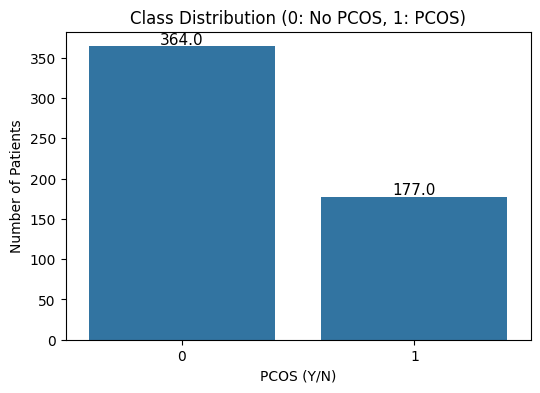

In [4]:
# ============ Load & Clean Data ============
df = pd.read_csv(clinical_data_path)
df.columns = df.columns.str.strip()

# Coerce known numeric text columns if present
for col in ['II beta-HCG(mIU/mL)', 'AMH(ng/mL)']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop obvious ID/empty columns (adjust list to your CSV)
drop_cols = [c for c in ['Sl. No', 'Patient File No.', 'Unnamed: 44'] if c in df.columns]
df_cleaned = df.drop(columns=drop_cols)

assert TARGET_COLUMN in df_cleaned.columns, f"Missing target column: {TARGET_COLUMN}"
df_cleaned[TARGET_COLUMN] = df_cleaned[TARGET_COLUMN].astype(int)

X_full = df_cleaned.drop(columns=[TARGET_COLUMN])
y_full = df_cleaned[TARGET_COLUMN]

# Identify dtypes
numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_full.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Columns: numeric={len(numeric_cols)}, categorical={len(categorical_cols)}")
print(f"Shape (full): {X_full.shape}, positives={y_full.sum()} ({y_full.mean():.3f} prevalence)")

# ============ NEW: Visualize Class Imbalance ============
plt.figure(figsize=(6, 4))
sns.countplot(x=y_full)
plt.title('Class Distribution (0: No PCOS, 1: PCOS)')
plt.xlabel('PCOS (Y/N)')
plt.ylabel('Number of Patients')
# Add annotations
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [5]:
# ============ Preprocessing pipelines ============
num_tf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    # (no scaler required for tree models)
])

cat_tf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_tf, numeric_cols),
        ('cat', cat_tf, categorical_cols)
    ],
    remainder='drop'
)

# ============ Train/Test split ============
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=RANDOM_STATE
)
neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Train={X_train.shape}, Test={X_test.shape}, Neg/Pos={neg_pos_ratio:.2f}")

Train=(432, 41), Test=(109, 41), Neg/Pos=2.06


In [6]:
# ============ Hyperparameter tuning (RandomizedSearchCV) ============
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        tree_method='hist',
        n_jobs=-1
    ))
])

param_dist_xgb = {
    'classifier__n_estimators': randint(200, 800),
    'classifier__learning_rate': loguniform(1e-2, 3e-1),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.25, 0.5, 1.0],
    'classifier__reg_alpha': [0, 0.1, 1.0, 5.0, 10.0],
    'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0],
    'classifier__scale_pos_weight': [neg_pos_ratio]
}

print("\n--- Tuning XGBoost (RandomizedSearchCV) ---")
xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=120, cv=5, n_jobs=-1,
    random_state=RANDOM_STATE,
    scoring='roc_auc', verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("\nBest XGBoost params:", xgb_search.best_params_)


--- Tuning XGBoost (RandomizedSearchCV) ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best XGBoost params: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 1.0, 'classifier__learning_rate': np.float64(0.170110026976697), 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 761, 'classifier__reg_alpha': 5.0, 'classifier__reg_lambda': 1.0, 'classifier__scale_pos_weight': np.float64(2.0638297872340425), 'classifier__subsample': 0.7}


In [7]:
# ============ Out-of-fold (OOF) probabilities for threshold tuning ============
print("\n--- Calibrating + OOF probabilities for threshold tuning (on TRAIN) ---")
# Use the tuned classifier base (without calibration) for OOF
best_clf = best_xgb.named_steps['classifier']
best_pre = best_xgb.named_steps['preprocessor']

# Build calibrated wrappers (for later comparison on TEST)
platt = CalibratedClassifierCV(estimator=best_clf, method='sigmoid', cv=5)
iso = CalibratedClassifierCV(estimator=best_clf, method='isotonic', cv=5)

platt_pipe = Pipeline([('pre', best_pre), ('cal', platt)])
iso_pipe = Pipeline([('pre', best_pre), ('cal', iso)])

# OOF probs for threshold finding (avoid leakage)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = cross_val_predict(
    iso_pipe, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1
)[:,1]

# F1-optimal threshold on TRAIN
thresholds = np.linspace(0.05, 0.95, 181)
f1_scores = [f1_score(y_train, (oof_proba >= t).astype(int)) for t in thresholds]
best_t_f1 = float(thresholds[int(np.argmax(f1_scores))])
# Highest threshold achieving Recall ≥ 0.90 on TRAIN
t_recall90 = threshold_for_target_recall(y_train.values, oof_proba, target_recall=0.90)
print(f"Best threshold by OOF F1: {best_t_f1:.3f}")
print(f"Threshold meeting Recall ≥ 0.90 (OOF): {t_recall90:.3f}" if t_recall90 else "No threshold meets Recall≥0.90")


--- Calibrating + OOF probabilities for threshold tuning (on TRAIN) ---
Best threshold by OOF F1: 0.360
Threshold meeting Recall ≥ 0.90 (OOF): 0.203


In [8]:
# ============ Fit calibration on full TRAIN, evaluate on TEST ============
platt_pipe.fit(X_train, y_train)
iso_pipe.fit(X_train, y_train)

proba_platt = platt_pipe.predict_proba(X_test)[:,1]
proba_iso = iso_pipe.predict_proba(X_test)[:,1]

def summarize_set(name, y, p):
    return dict(
        name=name,
        auroc=roc_auc_score(y,p),
        auprc=average_precision_score(y,p),
        brier=brier_score_loss(y,p)
    )

sum_platt = summarize_set("Platt", y_test, proba_platt)
sum_iso = summarize_set("Isotonic", y_test, proba_iso)

print("\n--- Calibration comparison on TEST ---")
for s in (sum_platt, sum_iso):
    print(f"{s['name']}: AUROC={s['auroc']:.3f} | AUPRC={s['auprc']:.3f} | Brier={s['brier']:.3f}")

# Choose calibrated model (pick isotonic by default; switch if Platt is clearly better)
calibrated_name = "Isotonic" if sum_iso['brier'] <= sum_platt['brier'] else "Platt"
proba_test_xgb = proba_iso if calibrated_name == "Isotonic" else proba_platt
final_xgb_pipe = iso_pipe if calibrated_name == "Isotonic" else platt_pipe
print(f"\nSelected calibration: {calibrated_name}")

# ============ NEW: Measure Inference Time ============
n_test = len(X_test)
start_time = time.time()
# The prediction step is timed here
_ = final_xgb_pipe.predict_proba(X_test)
end_time = time.time()
total_time = end_time - start_time
avg_time_per_sample = total_time / n_test
print(f"\n--- Inference Time ---")
print(f"Total time for {n_test} samples: {total_time:.4f} seconds")
print(f"Average time per sample: {avg_time_per_sample*1000:.4f} ms")


# ============ Headline metrics with 95% bootstrap CIs ============
auroc, auroc_ci = bootstrap_ci(y_test.values, proba_test_xgb, roc_auc_score)
auprc, auprc_ci = bootstrap_ci(y_test.values, proba_test_xgb, average_precision_score)
brier = brier_score_loss(y_test, proba_test_xgb)
print(f"\nTEST (XGB): AUROC={auroc:.3f} [{auroc_ci[0]:.3f}, {auroc_ci[1]:.3f}] | "
      f"AUPRC={auprc:.3f} [{auprc_ci[0]:.3f}, {auprc_ci[1]:.3f}] | "
      f"Brier={brier:.3f}")

# ============ Threshold metrics on TEST ============
tm_f1 = threshold_metrics(y_test.values, proba_test_xgb, best_t_f1)
if t_recall90:
    tm_rec = threshold_metrics(y_test.values, proba_test_xgb, t_recall90)
else:
    tm_rec = None

print(f"\n@thr=F1-opt ({best_t_f1:.3f}) -> "
      f"Precision={tm_f1['precision']:.3f}, Recall={tm_f1['recall']:.3f}, F1={tm_f1['f1']:.3f}")

if tm_rec:
    print(f"@thr=Recall≥0.90 ({t_recall90:.3f}) -> "
          f"Precision={tm_rec['precision']:.3f}, Recall={tm_rec['recall']:.3f}, F1={tm_rec['f1']:.3f}")


--- Calibration comparison on TEST ---
Platt: AUROC=0.956 | AUPRC=0.945 | Brier=0.069
Isotonic: AUROC=0.959 | AUPRC=0.949 | Brier=0.065

Selected calibration: Isotonic

--- Inference Time ---
Total time for 109 samples: 0.0195 seconds
Average time per sample: 0.1793 ms

TEST (XGB): AUROC=0.959 [0.911, 0.993] | AUPRC=0.949 [0.891, 0.988] | Brier=0.065

@thr=F1-opt (0.360) -> Precision=0.838, Recall=0.861, F1=0.849
@thr=Recall≥0.90 (0.203) -> Precision=0.717, Recall=0.917, F1=0.805


In [9]:
# ============ NEW: Baseline Model (Logistic Regression) ============
print("\n--- Training and Evaluating Baseline: Logistic Regression ---")

# We reuse the same preprocessor but pair it with a Logistic Regression classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear', # Good for smaller datasets
        class_weight='balanced', # Handles imbalance
        max_iter=1000
    ))
])

# Fit on the training data
lr_pipeline.fit(X_train, y_train)

# Predict probabilities on the test data
proba_test_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the baseline model
lr_auroc = roc_auc_score(y_test, proba_test_lr)
lr_auprc = average_precision_score(y_test, proba_test_lr)
lr_brier = brier_score_loss(y_test, proba_test_lr)

print(f"TEST (Logistic Regression): AUROC={lr_auroc:.3f} | AUPRC={lr_auprc:.3f} | Brier={lr_brier:.3f}")


--- Training and Evaluating Baseline: Logistic Regression ---
TEST (Logistic Regression): AUROC=0.947 | AUPRC=0.930 | Brier=0.090


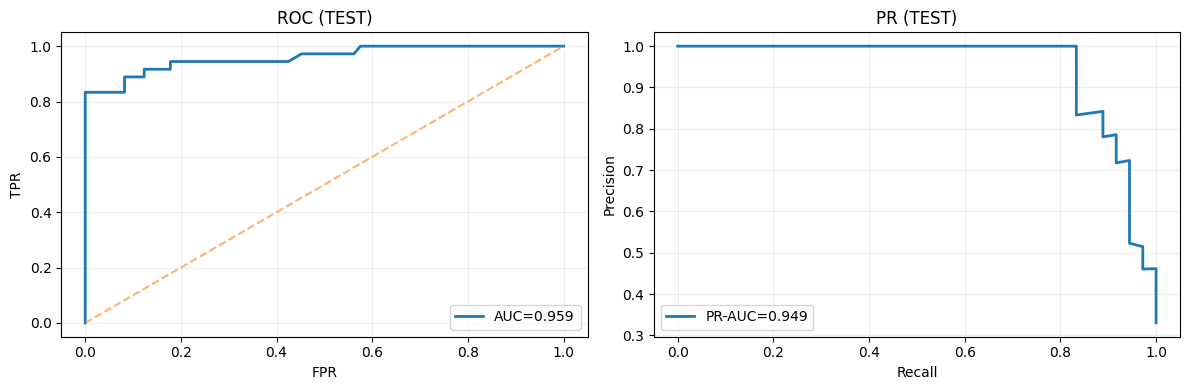

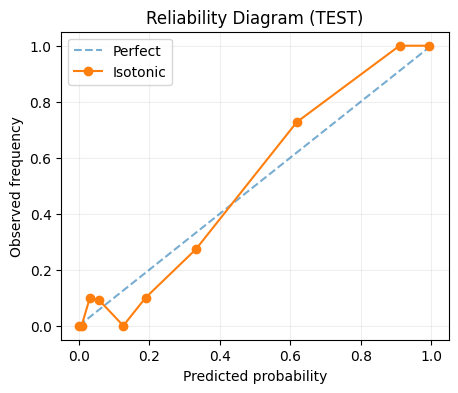

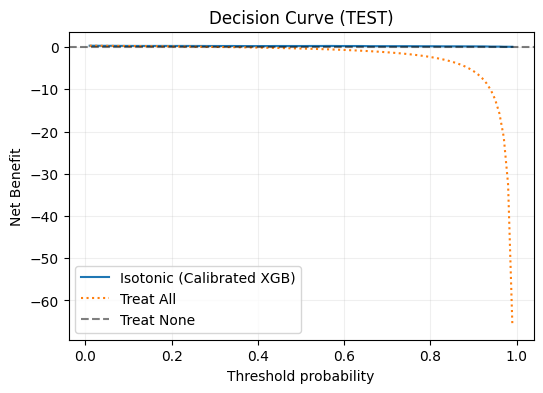

In [10]:
# ============ Plots: ROC, PR, Reliability, Decision Curve ============
# ROC & PR
fpr, tpr, _ = roc_curve(y_test, proba_test_xgb)
prec, rec, _ = precision_recall_curve(y_test, proba_test_xgb)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, lw=2, label=f'AUC={auroc:.3f}')
plt.plot([0, 1], [0, 1], '--', alpha=0.6)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (TEST)'); plt.legend(); plt.grid(alpha=0.2)

plt.subplot(1, 2, 2)
plt.plot(rec, prec, lw=2, label=f'PR-AUC={auprc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (TEST)'); plt.legend(); plt.grid(alpha=0.2)
plt.tight_layout()
if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, "roc_pr.png"), dpi=200)
plt.show()

# Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, proba_test_xgb, n_bins=10, strategy='quantile')
plt.figure(figsize=(5, 4))
plt.plot([0, 1], [0, 1], '--', alpha=0.6, label='Perfect')
plt.plot(prob_pred, prob_true, marker='o', label=f'{calibrated_name}')
plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
plt.title('Reliability Diagram (TEST)'); plt.legend(); plt.grid(alpha=0.2)
if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, "reliability.png"), dpi=200)
plt.show()

# Decision Curve
thr, nb = decision_curve(y_test.values, proba_test_xgb)
prev = y_test.mean()
treat_all = prev - (1-prev) * (thr/(1-thr))
plt.figure(figsize=(6, 4))
plt.plot(thr, nb, label=f'{calibrated_name} (Calibrated XGB)')
plt.plot(thr, treat_all, ':', label='Treat All')
plt.axhline(0, ls='--', c='k', alpha=0.5, label='Treat None')
plt.xlabel('Threshold probability'); plt.ylabel('Net Benefit'); plt.title('Decision Curve (TEST)')
plt.legend(); plt.grid(alpha=0.2)
if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, "decision_curve.png"), dpi=200)
plt.show()


--- SHAP analysis ---


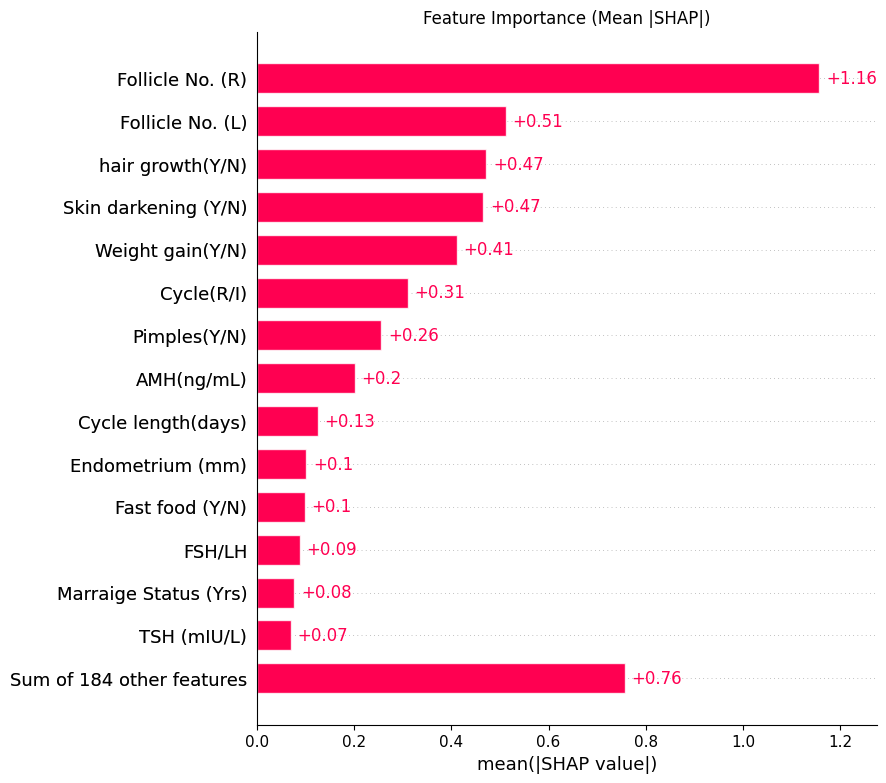

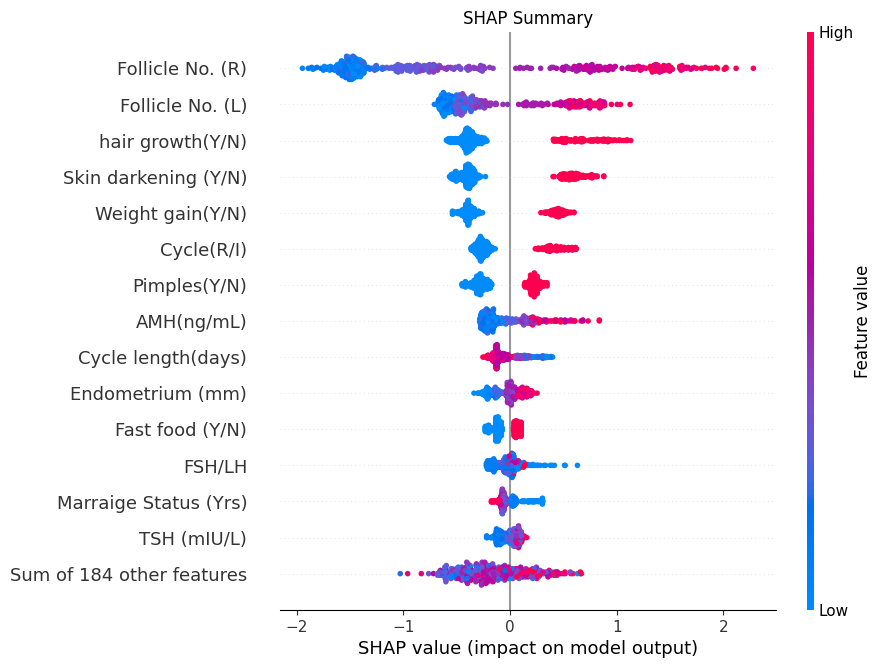

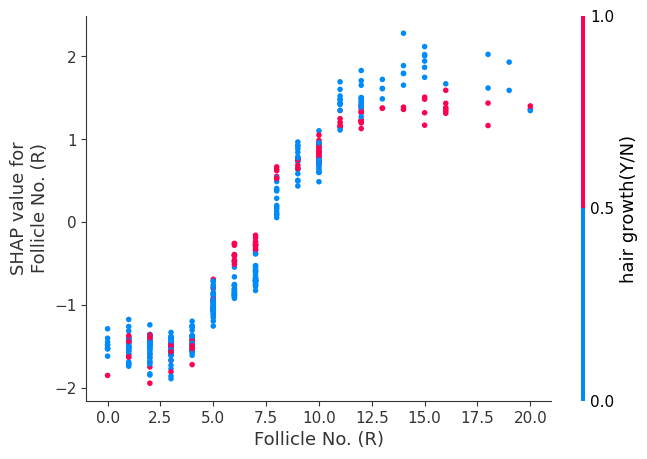

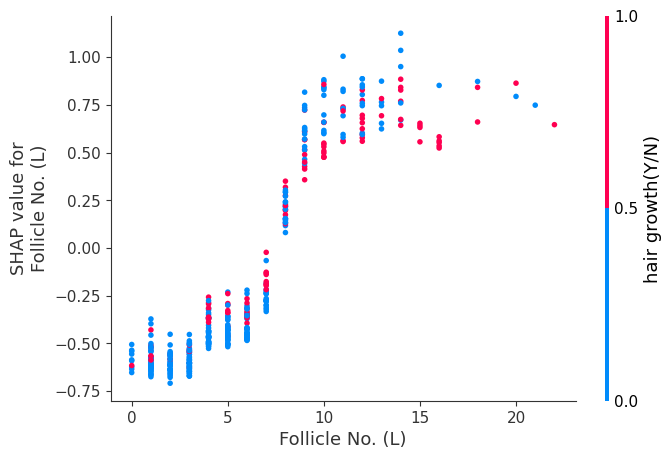

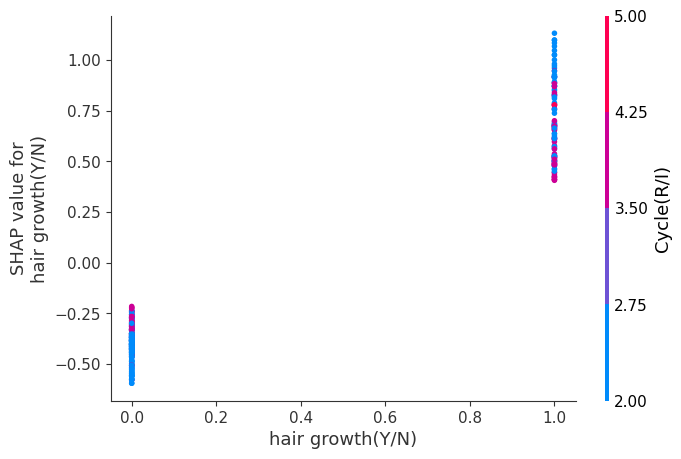

In [11]:
# ============ SHAP: global, beeswarm, dependence ============
print("\n--- SHAP analysis ---")
# Transform TRAIN to match model inputs, build feature names (numeric + one-hot)
X_train_proc = best_pre.transform(X_train)
num_names = numeric_cols
cat_names = []
if len(categorical_cols) > 0:
    ohe = best_pre.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = num_names + cat_names
X_train_proc_df = pd.DataFrame(X_train_proc, columns=feature_names)

# SHAP on tuned, uncalibrated classifier
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer(X_train_proc_df, check_additivity=False)

# Global bar plot
plt.title("Feature Importance (Mean |SHAP|)")
shap.plots.bar(shap_values, max_display=15, show=False)
if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, "shap_bar.png"), bbox_inches='tight', dpi=200)
plt.show()

# Beeswarm plot
plt.title("SHAP Summary")
shap.plots.beeswarm(shap_values, max_display=15, show=False)
if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, "shap_beeswarm.png"), bbox_inches='tight', dpi=200)
plt.show()

# Dependence plots for top-3 features
mean_abs = np.abs(shap_values.values).mean(0)
order = np.argsort(-mean_abs)
top3_idx = order[:3]
for i in top3_idx:
    shap.dependence_plot(i, shap_values.values, X_train_proc_df, feature_names=feature_names, show=False)
    if SAVE_ARTIFACTS: plt.savefig(os.path.join(ARTIFACT_DIR, f"shap_dep_{feature_names[i]}.png"), bbox_inches='tight', dpi=200)
    plt.show()

In [12]:
# ============ NEW: Error Analysis ============
print("\n--- Error Analysis on Test Set ---")

# Get predictions at the F1-optimal threshold
y_pred_xgb = (proba_test_xgb >= best_t_f1).astype(int)

# Identify misclassified samples
misclassified_indices = y_test[y_test != y_pred_xgb].index

# Separate False Positives (FP) and False Negatives (FN)
fp_indices = y_test[(y_test == 0) & (y_pred_xgb == 1)].index
fn_indices = y_test[(y_test == 1) & (y_pred_xgb == 0)].index

print(f"Total misclassified: {len(misclassified_indices)}")
print(f"False Positives (Predicted 1, Actually 0): {len(fp_indices)}")
print(f"False Negatives (Predicted 0, Actually 1): {len(fn_indices)}")

# Display top 5 SHAP features for a few misclassified samples
top5_shap_features = [feature_names[i] for i in order[:5]]

print("\n--- Sample False Positives ---")
# We use .loc to select rows from the original, un-preprocessed X_test
display(X_test.loc[fp_indices].head(3)[top5_shap_features])


print("\n--- Sample False Negatives ---")
display(X_test.loc[fn_indices].head(3)[top5_shap_features])


--- Error Analysis on Test Set ---
Total misclassified: 11
False Positives (Predicted 1, Actually 0): 6
False Negatives (Predicted 0, Actually 1): 5

--- Sample False Positives ---


,Follicle No. (R),Follicle No. (L),hair growth(Y/N),Skin darkening (Y/N),Weight gain(Y/N)
466,9,11,0,0,0
279,2,3,1,1,1
377,7,8,0,0,1



--- Sample False Negatives ---


,Follicle No. (R),Follicle No. (L),hair growth(Y/N),Skin darkening (Y/N),Weight gain(Y/N)
444,1,1,0,0,0
227,3,1,1,1,1
276,5,6,0,0,1


In [13]:
# ============ Consolidated results table ============
rows = []
rows.append({
    "Model": f"Calibrated XGB ({calibrated_name})",
    "AUROC": round(auroc, 3),
    "PR_AUC": round(auprc, 3),
    "Brier": round(brier, 3),
    "Avg Inference (ms)": round(avg_time_per_sample * 1000, 4)
})

rows.append({
    "Model": "Logistic Regression (Baseline)",
    "AUROC": round(lr_auroc, 3),
    "PR_AUC": round(lr_auprc, 3),
    "Brier": round(lr_brier, 3),
    "Avg Inference (ms)": "N/A" # Could be measured, but typically very fast
})

results_table = pd.DataFrame(rows)
print("\n--- Final Model Comparison ---")
pd.set_option('display.max_columns', None)
print(results_table)

if SAVE_ARTIFACTS:
    results_table.to_csv(os.path.join(ARTIFACT_DIR, "model_comparison.csv"), index=False)

print("\nDone ✅")


--- Final Model Comparison ---
                            Model  AUROC  PR_AUC  Brier Avg Inference (ms)
0       Calibrated XGB (Isotonic)  0.959   0.949  0.065             0.1793
1  Logistic Regression (Baseline)  0.947   0.930  0.090                N/A

Done ✅


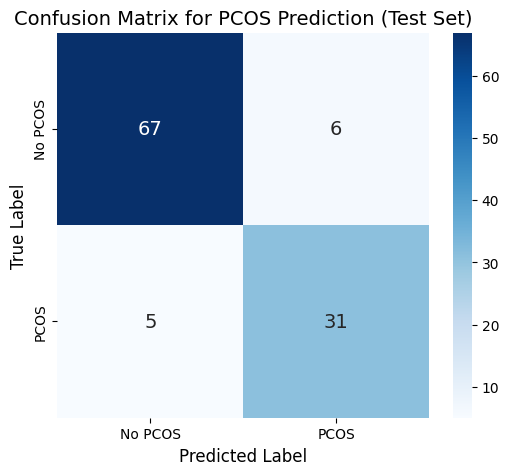

In [14]:
# ============ NEW: Confusion Matrix Visualization ============
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Create a figure and axes
plt.figure(figsize=(6, 5))

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No PCOS', 'PCOS'],
            yticklabels=['No PCOS', 'PCOS'],
            annot_kws={"size": 14}) # Increase font size of numbers

# Add labels and a title
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for PCOS Prediction (Test Set)', fontsize=14)
plt.show()